In [63]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import csv
import pandas as pd
import json
import time
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import string 
import unicodedata as ud
from greek_stemmer import GreekStemmer
import pymongo
import numpy as np
import re
import networkx as nx
import indexer as ind


### Find candidate domain-specific stopwords and clean index

In [73]:
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
#mongo_client.drop_database("GreekParliamentProceedings")
client = mongo_client["GreekParliamentProceedings"]
index = client["InvertedIndex"]
database = client["Database"]
with open('stopwords.txt', encoding='utf-8') as file:
  stopwords = [line.rstrip() for line in file]
with open('domain-specific-stopwords.txt', encoding='utf-8') as file:
  domain_specific_stopwords = [line.rstrip() for line in file]

In [20]:
numdocs = list(index.find({ }, { "_id": 0, "list.numdoc": 1 }))
x = [numdocs[i]['list']['numdoc'] for i in range(len(numdocs))]
numdocs = {}
for numdoc in set(x):
    numdocs[numdoc] = x.count(numdoc)

In [21]:
print(f'Υπαρχουν {numdocs[1267]} documents με numdoc==1267')

Υπαρχουν 1 documents με numdoc==1267


(array([3052.,  794.,  315.,  180.,  110.,   86.,   63.,   43.,   38.,
          22.,   20.,   14.,   14.,   12.,   11.,    8.,    7.,    4.,
           8.,    5.,    4.,    5.,    5.]),
 array([     0.,   5000.,  10000.,  15000.,  20000.,  25000.,  30000.,
         35000.,  40000.,  45000.,  50000.,  55000.,  60000.,  65000.,
         70000.,  75000.,  80000.,  85000.,  90000.,  95000., 100000.,
        105000., 110000., 115000.]),
 <BarContainer object of 23 artists>)

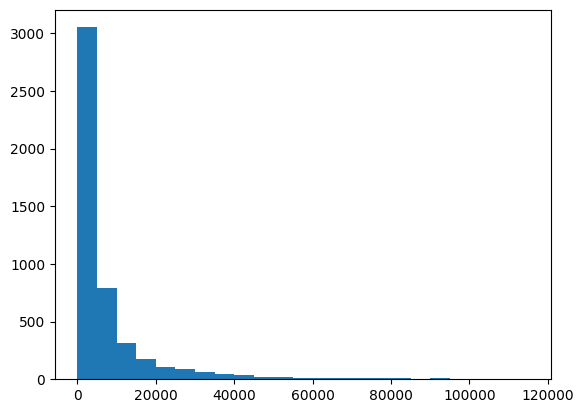

In [22]:
import matplotlib.pyplot as plt
n_bins = 20

# Generate two normal distributions

fig, axs = plt.subplots()

# We can set the number of bins with the *bins* keyword argument.
axs.hist(numdocs, bins=[i for i in range(0,120000,5000)])

In [ ]:
threshold = list(index.find({"list.numdoc":{"$gt":100000}}, { "_id": 1, "list.numdoc": 1 }))
print([threshold[i]['_id'] for i in range(len(threshold))])
with open('domain-specific-stopwords.txt', 'w', encoding='utf8') as f:
    for i in range(len(threshold)):
        f.write(threshold[i]['_id'])
        f.write('\n')

In [26]:
threshold = list(index.find({"list.numdoc":{"$lt":3}}, { "_id": 1, "list.numdoc": 1 }))
print([threshold[i]['_id'] for i in range(len(threshold))][200:230])
print(len(threshold))

['τσαλδαρης)', 'μισσαηλιδ', 'παραβολον', 'επικυρουτα', 'επιδειχθεντ', 'εγλιτως', 'επλαστογραφ', '0112', 'αλφοnσινα', 'αλφοσιν', 'εισπλευς', 'αυταδρον', 'alfonsinα', 'καθαρσολογ', 'χασομ', 'κρινομ', 'περασομ', '0116μα', '68/88', '2891/77', 'εκακ)', '1697/79', '2891/77)', 'lloyd', 'φλαμιγκ', 'ιtco', 'πραγματοποιηθηκεσελιδ', '0117', 'επιστραφεν', 'κατεβλευς']
316424


In [7]:
import re

to_remove = list(index.find({"_id":{"$regex":"^[0-9][0-9][0-9].*[α-ω]$"}},{ "_id": 1, "list": 0}))
#x = re.findall("^[0-9][0-9][0-9].*[α-ω]$", txt)
print(to_remove[:100])

[{'_id': '000/8/245258/σ'}, {'_id': '000/οικ'}, {'_id': '0000%απο'}, {'_id': '00010ο'}, {'_id': '00012%απο'}, {'_id': '00016%απο'}, {'_id': '0002%απο'}, {'_id': '00020%απο'}, {'_id': '00024%απο'}, {'_id': '0002γραφημα'}, {'_id': '0002θεωρουμε'}, {'_id': '0003%απο'}, {'_id': '0003επιλεξει'}, {'_id': '0004γων'}, {'_id': '0006%απο'}, {'_id': '0006που'}, {'_id': '0008%απο'}, {'_id': '0008μοκρατια'}, {'_id': '0008ο'}, {'_id': '0009ορισμενες'}, {'_id': '000αλλοτε'}, {'_id': '000αυτα'}, {'_id': '000β'}, {'_id': '000γ'}, {'_id': '000για'}, {'_id': '000δ'}, {'_id': '000διδακτικο'}, {'_id': '000δραχμες'}, {'_id': '000δραχμων'}, {'_id': '000δρχ'}, {'_id': '000ε'}, {'_id': '000επι'}, {'_id': '000ετος'}, {'_id': '000ευρω'}, {'_id': '000η'}, {'_id': '000και'}, {'_id': '000καταστηματαρχες'}, {'_id': '000μοναδων'}, {'_id': '000νται'}, {'_id': '000ο'}, {'_id': '000πανω'}, {'_id': '000προηγουμενησμετ'}, {'_id': '000σελιδα'}, {'_id': '000στρ'}, {'_id': '000στρεμματα'}, {'_id': '000στρεμματων'}, {'_id': '

In [39]:
speeches = list(database.find({}, { "_id": 0, "speech": 1 }))

In [42]:
print(speeches[1]['speech'])

 Παρακαλείται ο κύριος Γραμματέας να συνοδεύσει την Ιερά Σύνοδο εκτός της Αιθούσης της Βουλής.  . Παρακαλείται ο συνάδελφος Βουλευτής κ. Σαδίκ Αμέτ, που ανήκει στο Μωαμεθανικό Θρήσκευμα να προσέλθει και να δώσει τον οριζόμενο από το Σύνταγμα όρκο επί του Κορανίου.  : ~"Ορκίζομαι στο όνομα του Παντοδύναμου Θεού και του μόνου αυτού Προφήτη ο οποίος είναι ο Μωάμεθ να είμαι πιστός στην πατρίδα και το δημοκρατικό πολίτευμα, να υπακούω στο Σύνταγμα και τους νόμους και να εκπληρώνω ευσυνείδητα τα καθήκοντά μου".


In [46]:
counter = 0
for i,speech in enumerate(speeches):
    words = ind.preprocess_doc(speech['speech'], stopwords)
    if(len(words)<10):
        counter+=1

### Single Document Keyword Extraction with python libraries

In [182]:
def preprocess_doc(doc: str, stopwords:list, domain_specific_stopwords:list) -> list:
    doc = doc.lower()
    d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
    doc = ud.normalize('NFD',doc).translate(d)
    stemmer = GreekStemmer()
    #doc = doc.lower()
    if doc!="":
        words = [w.lower() for w in filter(None, re.split('[,~`; _".\-!?:]+',doc)) if w not in stopwords]
    if(len(words)>0):
        words = [w for w in words if stemmer.stem(w.upper()).lower() not in domain_specific_stopwords]
    return words

In [220]:
document = list(database.find({"_id":"9433"}, { "_id": 0, "speech": 1 }))
doc = document[0]['speech']
words_in_row = preprocess_doc(document[0]['speech'], stopwords, domain_specific_stopwords)

In [221]:
import yake
with open('stopwords.txt', encoding='utf-8') as file:
  stopwords = [line.rstrip() for line in file]
speech = ""
for term in words_in_row:
  speech = speech+term+" "
kw_extractor = yake.KeywordExtractor(top=10, stopwords=stopwords)
keywords = kw_extractor.extract_keywords(speech)
for kw, v in keywords:
  print("Keyphrase: ",kw, ": score", v)

Keyphrase:  ειδικοτερα προγραμματικες δηλωσεις : score 8.579318457909193e-05
Keyphrase:  προγραμματικες δηλωσεις δικη : score 0.00013720628931042936
Keyphrase:  κινειται σωστη κατευθυνση : score 0.00014094022588148584
Keyphrase:  υψιστα εθνικα συμφεροντα : score 0.0001513729777914375
Keyphrase:  αποτελεσει πληρη λυση : score 0.00015527104155253394
Keyphrase:  εναλλαγη κομματων εξουσια : score 0.0001608684543638805
Keyphrase:  εντυπωση προγραμματικες δηλωσεις : score 0.0001737286886668344
Keyphrase:  προγραμματικες δηλωσεις ηθελα : score 0.00017484127301558102
Keyphrase:  αρχων προγραμματικες δηλωσεις : score 0.00017486268389163532
Keyphrase:  χαιρομαι προγραμματικες δηλωσεις : score 0.00017783296595049648


In [222]:
#compare with graph of words
#keywords = get_keywords(database, "9433", nx.in_degree_centrality)
#print(keywords[:20])
keywords, scores = get_keywords(database, "9433", nx.pagerank)
print(keywords[:])
#keywords = get_keywords(database, "9433", nx.betweenness_centrality)
print(keywords[:20])
#print((scores))

['λυση', 'εκλογες', 'αναγκη', 'νομιζω', 'αποτελει', 'οικουμενικη', 'ωρα', 'προγραμμα', 'κομματα', 'μετρα', 'ιδιαιτερα', "σ'", 'πασοκ', 'κομματων', 'κομμα', 'λαο', 'προγραμματικες', 'επρεπε', 'δις', 'δικη', 'βεβαιο', 'λαου', 'αποψη', 'αποτελεσει', 'αρχη', 'λεω', 'ελλειμματα', 'τομεα', 'ηθελα', 'ελλειμμα', 'βεβαιος', 'πλειοψηφια', 'δηλωσεις', 'εσοδα', 'συνεργασια', 'προϋπολογισμο', 'σχεσεις', 'αλλωστε', 'προχωρησουμε', 'απετελεσε', 'ελλαδα', 'δυνατον', 'κομματος', 'αμφιβολια', 'ευθυνη', 'συζητηση', 'παιδειας', 'τελος', 'αριστερας', 'τελευταιο', 'σ', 'εγινε', 'υγειας', 'δεχεται', 'καιρο', 'πραγματα', 'νεα', 'οικουμενικης', 'δικαιωμα', 'πραγματικοτητα', 'σωστη', 'τρια', 'ιουνιο', 'υπηρχε', 'κατηγορηματικα', 'πιστευουμε', 'βιος', 'μιλησω', 'δωσει', 'σημεια', 'απλως', 'ελλας', 'συστημα', 'εντυπωση', 'εγγυησεις', 'πορεια', 'τελευταια', 'μονοπωλιο', 'τρεις', 'αρχων', 'εργο', 'μουσουλμανικης', 'αιθουσα', "απ'", 'δεκεμβριου', 'συγκλιση', 'υπαρκτο', 'δισεκατομμυρια', 'ελλαδος', 'επομενη', 'απριλ

In [207]:
import spacy
from spacy.tokens import Token
def transform_uni_to_ngram(unigram_keywords, text):
  """
  Candidate unigrams that form ngrams in the text
  are merged and now form a single candidate keyphrase.
  """
  # set the spacy model
  nlp = spacy.load("el_core_news_md")

  # function that tells if spacy token is keyword or not
  ckw_getter = lambda token: token.text.lower() in unigram_keywords
  
  # set that function as token extension (as attribute with ._)
  Token.set_extension("is_ckw", getter=ckw_getter, force=True)

  # variable to store resulting keyphrases
  res = []
  
  # split original text in sentences
  sentences = nltk.sent_tokenize(text)
  #print(sentences)
  for sent in sentences:
      # start keyphrase as empty string
      merged_tokens = ''
      
      # process sentence with spacy model defined beforehand
      sent = nlp(sent)
      preprocess = preprocess_doc(sent.text, stopwords, domain_specific_stopwords)
      sent = ""
      for word in preprocess:
          sent = sent + word + " "
      for token in nlp(sent):
          #print(token)
          # if token is candidate KW (according to func defined before)
          if token._.is_ckw:
              # add it to keyphrase
                merged_tokens += token.text.lower() + ' '
         
         # means that sequence of tokens in text that are candidate KW ends
          else:
              # check if keyphrase not empty and already not in list of results
              if merged_tokens != '' and merged_tokens.strip() not in res:
                  
                  # only add keyphrases for now, no unigrams
                  if len(merged_tokens.strip().split(' ')) != 1:
                      res.append(merged_tokens.strip())
                  
                  # set keyphrase as empty string again
                  merged_tokens = ''


  for uni in unigram_keywords:
      # only add unigram KW to results list if not there already
      if uni not in res:
          
          add_uni = True
          
          for other in res:  
              # only add unigram KW to results list if not used in keyphrase somewhere
              if uni in other:
                  add_uni = False
          
          if add_uni:
              res.append(uni)   
  
  return res

In [223]:
res = transform_uni_to_ngram(keywords[:10], doc)

In [224]:
print(type(keywords[:10]))
print(type(doc))

<class 'list'>
<class 'str'>


In [199]:
print(res)

['κομματων πασοκ', 'λυση οικουμενικη αναγκη', 'κομμα πασοκ', 'λυση πασοκ', 'κομμα νομιζω', 'μετρα οικουμενικη', 'οικουμενικη κομμα', 'νομιζω ωρα', "κομματα σ'", 'λυση αποτελει', 'κομματα αναγκη', 'εκλογες εκλογες', 'λυση ωρα λυση εκλογες', 'προγραμμα', 'ιδιαιτερα']


In [ ]:
print(get_keywords(database, "0"))

In [214]:
import spacy

nlp = spacy.load("el_core_news_md")
doc = nlp(doc)

for token in doc:
    print(token,token.pos_,)

  SPACE
Κυρίες NOUN
και CCONJ
κύριοι ADJ
συνάδελφοι NOUN
, PUNCT
η DET
ορκωμοσία NOUN
της DET
Κυβέρνησης NOUN
οικουμενικής ADJ
στήριξης NOUN
, PUNCT
υπό ADP
τον DET
καθηγητή NOUN
και CCONJ
Ακαδημαϊκόν PROPN
κ. NOUN
Ξενοφώντα PROPN
Ζολώτα PROPN
, PUNCT
απετέλεσε VERB
χωρίς ADP
αμφιβολία NOUN
ένα DET
πολύ ADV
σημαντικό ADJ
πολιτικό ADJ
γεγονός NOUN
για ADP
τον DET
Τόπο NOUN
μας PRON
. PUNCT
Ιστορικά ADV
αν SCONJ
το PRON
δούμε VERB
, PUNCT
είναι AUX
η DET
δεύτερη NUM
στη ADP
διάρκεια NOUN
του DET
αιώνα NOUN
που PRON
κλείνει VERB
, PUNCT
οικουμενική ADJ
κυβέρνηση NOUN
που PRON
σχηματίζεται VERB
στην ADP
Ελλάδα PROPN
. PUNCT
Και CCONJ
στην ADP
ουσία NOUN
είναι AUX
η DET
πρώτη NUM
η DET
οποία PRON
καλύπτει VERB
ολόκληρο ADJ
το DET
πολιτικό ADJ
φάσμα NOUN
. PUNCT
Γιατί ADV
η DET
οικουμενική ADJ
κυβέρνηση NOUN
του DET
Ζαΐμη NOUN
το DET
1926 NUM
δεν PART
περιελάμβανε VERB
το DET
υπαρκτό ADJ
τότε ADV
, PUNCT
στην ADP
Ελλάδα PROPN
, PUNCT
Κομμουνιστικό ADJ
Κόμμα NOUN
. PUNCT
Είναι AUX
προφανές AD

### Single Document Keyword Extraction with Networkx

In [122]:
def create_graph_of_words(words_in_row:list)->nx.DiGraph:
    """Creates a graph of words for a single document
    
    """
    g = nx.DiGraph()
    #add unique words as nodes of the graph
    g.add_nodes_from(set(words_in_row))
    for j,word in enumerate(words_in_row):
        #add word as a node if it doesnt exist
        #if word not in g.nodes:
            #g.add_node(word)    
        #generate list of indexes
        gen = (x for x in range(j+1,j+3) if x<len(words_in_row))
        for k in gen:
            #avoid self-loops
            if(word == words_in_row[k]):
                pass
            #if edge does not exist create it, else increase edge weight
            elif((word, words_in_row[k]) not in g.edges):
                g.add_edge(word, words_in_row[k])
                g[word][words_in_row[k]]['weight'] = 1
            else:
                g[word][words_in_row[k]]['weight'] += 1
    return g

def generate_graphs(total_documents:int, chunksize:int, database_collection):
    """Creates graphs of words for documents of a given collection of documents
    
    """
    chunk = []
    counter = 0
    start_time = time.time()
    #get inverted index
    ticks = [x for x in range(0,total_documents,chunksize)]
    ticks.append(total_documents)
    graphs=[]
    with open('stopwords.txt', encoding='utf-8') as file:
        stopwords = [line.rstrip() for line in file]
    for j in range(len(ticks)-1):
        tokens = {}
        chunk = list(database_collection.find({ }, { "_id": 1, "speech": 1 })[ticks[j]:ticks[j+1]])
        print("Length of chunk: ", len(chunk))
        size_distribution = []
        #chunk = ["This is a sentance","This is another one"]
        #for each speech
        for i, row in enumerate(chunk):
            words_in_row = ind.preprocess_doc(row["speech"], stopwords)
            graph = create_graph_of_words(words_in_row)
            graphs.append(graph)
   
        #insert chunk of tokens to a mongo collection named index
        
        print("CHUNK", counter, " FINISHED")
    
    return graphs
def weighted_undirected_k_core(graph:nx.Graph):
    k = 0
    core_numbers = dict([(node,0) for node in graph.nodes])
    degrees = dict(graph.degree(weight='weight'))
    while(len(graph.nodes)>0):
        min_node = get_min_node(degrees)
        #print(min_node)
        if(degrees[min_node]>k):
            core_numbers[min_node] = degrees[min_node]
            k = core_numbers[min_node]
        else:
            core_numbers[min_node] = k
        for neighbor in graph.neighbors(min_node):
            degrees[neighbor] = degrees[neighbor]  - graph.get_edge_data(neighbor, min_node)['weight']
        graph.remove_node(min_node)
        del degrees[min_node]
        
    return core_numbers

def get_min_node(degrees):
    #sort degrees in increasing orders
    degrees = sorted(degrees.items(), key=lambda d: d[1])
    return degrees[0][0]

#returns the keywords for a document
def get_keywords(database_collection, document_id:string, criterion)->list:
    with open('stopwords.txt', encoding='utf-8') as file:
        stopwords = [line.rstrip() for line in file]
    with open('domain-specific-stopwords.txt', encoding='utf-8') as file:
        domain_specific_stopwords = [line.rstrip() for line in file]
    tokens = {}
    #read documents from MongoDB in chunks
    document = list(database_collection.find({"_id":document_id}, { "_id": 0, "speech": 1 }))
    size_distribution = []
    #chunk = ["This is a sentance","This is another one"]
    #for each speech
    words_in_row = preprocess_doc(document[0]['speech'], stopwords, domain_specific_stopwords)
    words_in_row = [word for word in words_in_row if word not in domain_specific_stopwords]
    graph = create_graph_of_words(words_in_row)
    #extract keywords and insert to mongo
    #core_numbers = weighted_undirected_k_core(graph)
    scores = criterion(graph)
    scores = dict(sorted(scores.items(), key=lambda item: -item[1]))
    #print(centrality)
    words = list(scores.keys())
    keywords = words[:int(len(words_in_row)/4)]

    return keywords, scores

#returns the keywords given a directed, unweighted graph of words
def extract_keywords(graph_of_words:nx.DiGraph)->list:
    """Extracts keywords from a graph of words
    
    """
    main_core = nx.k_core(graph_of_words)
    print("Graph size: ", len(graph_of_words.nodes))
    print("Main core size: ", len(main_core.nodes))
    main_core_centrality = nx.in_degree_centrality(main_core)
    print(main_core_centrality)
    values = main_core_centrality.values()
    keys = main_core_centrality.keys()
    
    #ToDo: find a criterion on which keywords to keep from main core
    import statistics as stats
    median = (stats.median(values))
    keywords = [keyword for keyword in main_core_centrality.keys() if main_core_centrality[keyword]>=median] 
    return keywords

In [16]:
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
#mongo_client.drop_database("GreekParliamentProceedings")
client = mongo_client["GreekParliamentProceedings"]
index = client["InvertedIndex"]
database = client["Database"]

In [218]:
#get keywords for a single document
keywords = get_keywords(database, "0", nx.pagerank)
print(keywords[:20])
import yake

with open('stopwords.txt', encoding='utf-8') as file:
  stopwords = [line.rstrip() for line in file]
document = list(database.find({"_id":"0"}, { "_id": 0, "speech": 1 }))
doc = document[0]['speech']
words_in_row = ind.preprocess_doc(document[0]['speech'], stopwords)
kw_extractor = yake.KeywordExtractor(top=10, stopwords=stopwords)
####

keywords = kw_extractor.extract_keywords(doc)
print( )
for kw, v in keywords:
  print("Keyphrase: ",kw, ": score", v)

(['αγιασμος', 'τελειται', 'καθιερωμενος', 'συνεχεια', 'τελεσθει'], {'αγιασμος': 0.18149804047638068, 'τελειται': 0.1267035821891177, 'καθιερωμενος': 0.10341248217540767, 'συνεχεια': 0.10057801752931335, 'τελεσθει': 0.03910736575973942, 'βουλης': 0.03838783573418155, 'αιθουσα': 0.037586714716542215, 'εισοδο': 0.0366948239093395, 'συνοδου': 0.035701724086802604, 'ιερας': 0.034596257304156636, 'μελη': 0.03336501862200992, 'συνοδευοντα': 0.031995158992048474, 'σεραφειμ': 0.030467986428723524, 'ελλαδος': 0.028771959862727434, 'πασης': 0.02687463922090011, 'αθηνων': 0.024781309119207215, 'αρχιεπισκοπο': 0.022410355357776992, 'μακαριοτατο': 0.01985582652698864, 'συνοδευσει': 0.016831640625, 'βουλγαρακης': 0.013845170454545457, 'γραμματεας': 0.009715909090909093, 'παρακαλειται': 0.00681818181818182})

Keyphrase:  Παρακαλείται ο Γραμματέας : score 0.019722776695850472
Keyphrase:  Μακαριότατο Αρχιεπίσκοπο Αθηνών : score 0.035654255249258755
Keyphrase:  Μακαριότατο Αρχιεπίσκοπο : score 0.10108917

In [28]:
import spacy
def transform_uni_to_ngram(unigram_keywords, text):
  """
  Candidate unigrams that form ngrams in the text
  are merged and now form a single candidate keyphrase.
  """
  # set the spacy model
  nlp = spacy.load("el_core_news_md")

  # function that tells if spacy token is keyword or not
  ckw_getter = lambda token: token.text.lower() in unigram_keywords
  
  # set that function as token extension (as attribute with ._)
  #token = token.set_extension("is_ckw", getter=ckw_getter, force=True)

  # variable to store resulting keyphrases
  res = []
  
  # split original text in sentences
  sentences = nltk.sent_tokenize(text)
  
  for sent in sentences:
      # start keyphrase as empty string
      merged_tokens = ''
      
      # process sentence with spacy model defined beforehand
      sent = nlp(sent)
      
      for token in sent:
          # if token is candidate KW (according to func defined before)
          token = token.set_extension("is_ckw", getter=ckw_getter, force=True)
          if token._.is_ckw:
              print(token)
              # add it to keyphrase
              merged_tokens += token.text.lower() + ' '
         
         # means that sequence of tokens in text that are candidate KW ends
          else:
              # check if keyphrase not empty and already not in list of results
              if merged_tokens != '' and merged_tokens.strip() not in res:
                  
                  # only add keyphrases for now, no unigrams
                  if len(merged_tokens.strip().split(' ')) != 1:
                      res.append(merged_tokens.strip())
                  
                  # set keyphrase as empty string again
                  merged_tokens = ''


  for uni in unigram_keywords:
      # only add unigram KW to results list if not there already
      if uni not in res:
          
          add_uni = True
          
          for other in res:  
              # only add unigram KW to results list if not used in keyphrase somewhere
              if uni in other:
                  add_uni = False
          
          if add_uni:
              res.append(uni)   
  
  return res

In [29]:
text = document = list(database.find({"_id":"63428"}, { "_id": 0, "speech": 1 }))

aaaa = transform_uni_to_ngram(keywords,text[0]['speech'])


AttributeError: 'NoneType' object has no attribute '_'

In [ ]:
#test, pls ignore
dataframe1 = list(database.find({ }, { "_id": 1, "speech": 1 })[:100000])
for i, row in enumerate(dataframe1):
    #print(row["_id"])
    pass

In [ ]:
#print(graphs[0].edges)
import matplotlib.pyplot as plt
 
plt.savefig('graph.png')
# larger figure size
#pos = nx.circular_layout(graphs[2])

plt.figure(3,figsize=(12,12)) 
nx.draw_networkx(graphs[0], with_labels=True,node_size=80,font_size=15)
plt.show()

### Extract keywords for a parliament member

In [28]:
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
#mongo_client.drop_database("GreekParliamentProceedings")
client = mongo_client["GreekParliamentProceedings"]
index = client["InvertedIndex"]
database = client["Database"]

In [29]:
#get distinct parliament member names in a list
member_names = database.distinct("member_name")

In [30]:
print(len(member_names))

1524


In [37]:
def get_member_keywords(member_name:string)->list:
    #get ids of member's total speeches
    member_speeches = list(database.find({"member_name": member_name}, { "_id": 1, "speech": 0 }))
    total_keywords = []
    for speech in member_speeches:
        keywords = get_keywords(database, speech['_id'])
        total_keywords.extend(keywords)
    keyword_frequency = {}
    for keyword in set(total_keywords):
        keyword_frequency[keyword] = total_keywords.count(keyword)
    keyword_frequency = sorted(keyword_frequency.items(), key=lambda d: d[1], reverse=True)
    return keyword_frequency[:50]

In [38]:
print(get_member_keywords(member_name=member_names[10]))

[('συγκεκριμεν', 128), ('γιατι', 101), ('περιπτως', 81), ('ηθελ', 70), ('ζητημ', 65), ('γεγον', 61), ('σχες', 61), ('λε', 55), ('βεβαιως', 53), ('γενικ', 52), ('πας', 44), ('πραγμ', 44), ('εργαζομεν', 43), ('αρθρ', 43), ('καταστας', 42), ('γνωμ', 42), ('νομιζ', 42), ('διαδικας', 41), ('ξερ', 41), ('μετρ', 40), ('συμβας', 40), ('στοιχει', 39), ('αναγκ', 39), ('κρατ', 38), ('σοβαρ', 38), ('ειδικ', 37), ('μιλ', 37), ('λειτουργ', 37), ('σημειως', 37), ("γι'", 36), ('θεωρ', 36), ('διαφορ', 36), ('στιγμ', 36), ('επιτροπ', 36), ('απαντης', 35), ('βας', 35), ('ρυθμις', 34), ('δημιουργ', 34), ('δικαιωμ', 34), ('δ', 34), ("απ'", 33), ('δυναμ', 33), ('πιστευ', 33), ('εταιρει', 32), ('σχεδ', 31), ('αποφας', 31), ('επιχειρης', 31), ('εγιν', 31), ('συμβουλ', 31), ('δευτ', 31)]


## Networkx library test

In [ ]:
#networkx library
import networkx as nx
g = nx.Graph()
l = ['1','2','3']
#g.add_nodes_from(l)

for word in l:
    if(word not in list(g.nodes)):
        g.add_node(word)
for e in list(g.nodes):
    print(e)
    
g.add_edge('1','2')
g.add_edge('2','3')
if(('1','2') in g.edges):
    print(' in')
for e in list(g.edges):
    print(e)

In [ ]:

graphs = generate_graphs(100,100,database)
graph = graphs[78]
for node in graph.nodes:
    for neighbor in graph.neighbors(node):
        if(graph.get_edge_data(neighbor, node)['weight']>1):
            print(graph.get_edge_data(neighbor, node)['weight'])

In [ ]:
core_numbers = dict(core_numbers)
max_core = [num for num in core_numbers.values() if(num==2)]
print(len(max_core))

In [ ]:
test = nx.Graph()
test.add_nodes_from([1,2,3,4,5,6])
test.add_edge(1,2)
test[1][2]['weight'] = 2
test.add_edge(1,4)
test[1][4]['weight'] = 4

test.add_edge(2,3)
test[2][3]['weight'] = 3

test.add_edge(3,4)
test[3][4]['weight'] = 5

test.add_edge(3,5)
test[3][5]['weight'] = 7

test.add_edge(4,5)
test[4][5]['weight'] = 6

test.add_edge(5,6)
test[5][6]['weight'] = 8



In [ ]:
k = 0
core_numbers = dict([(node,0) for node in test.nodes])
#print(graph.nodes)
print('sdfdsf.',len(nx.k_core(test).nodes))
degrees = dict(test.degree(weight='weight'))
while(len(test.nodes)>0):
    min_node = get_min_node(degrees)
    #print(min_node)
    if(degrees[min_node]>k):
        core_numbers[min_node] = degrees[min_node]
        k = core_numbers[min_node]
    else:
        core_numbers[min_node] = k
    for neighbor in test.neighbors(min_node):
        print(neighbor)
        degrees[neighbor] = degrees[neighbor]  - test.get_edge_data(min_node, neighbor)['weight']
    test.remove_node(min_node)
    del degrees[min_node]
    
print(sorted(core_numbers.items(), key=lambda d: d[1]))
print(len(core_numbers))

In [ ]:
graph = graphs[0]
#in+out degree
def get_graph_degrees(graph):
    degrees = [deg for deg in nx.degree(graph)]
    degrees = sorted(degrees,key=lambda d: d[1])
    degrees = dict(degrees)
    return degrees
core = {}
degrees = get_graph_degrees(graph)
print((degrees))
for vertex in degrees.keys():
    #print("Checking vertex: ", vertex)
    core[vertex] = degrees[vertex]
    neighbors = list(graph.predecessors(vertex)) + list(graph.successors(vertex))
    for neighbor in neighbors:
        #print(f"     Checking neighbors of vertex: {vertex}->{neighbor}")
        if(degrees[neighbor]>degrees[vertex]):
            degrees[neighbor] = degrees[neighbor] - 1
            #reorder degreesdictionary accordingly
            degrees = dict(sorted(degrees.items(),key=lambda d: d[1]))
print(core)
print((nx.k_core(graph).nodes))